In [1]:
import os
import numpy as np
import cv2

In [2]:
def get_background(file_path):
    
    cap = cv2.VideoCapture(file_path)
    # we will randomly select 50 frames for the calculating the median
    frame_indices = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=50)
    # we will store the frames in array
    frames = []
    for idx in frame_indices:
        # setting the frame index position to the indices that we have chosen randomly
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        frames.append(frame)
    # calculate the median
    median_frame = np.median(frames, axis=0).astype(np.uint8)
    
    cap.release()
    cv2.destroyAllWindows()
    
    return median_frame

In [3]:
VIDEO_PATH = os.path.join('data', 'match3.mp4')

In [4]:
background_model = get_background(VIDEO_PATH)

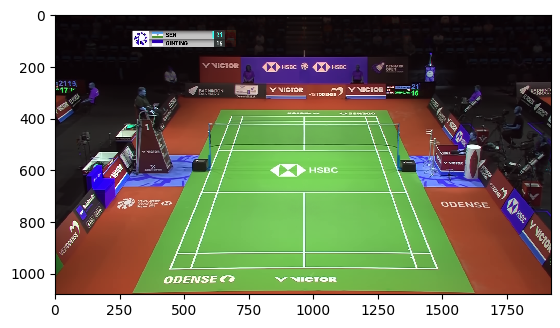

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(background_model, interpolation='nearest')
plt.show()

In [6]:
# convert the background model to grayscale format
background_model = cv2.cvtColor(background_model, cv2.COLOR_BGR2GRAY)

In [7]:
def detectMovingObjects(consecutive_frame, file_path):

    frame_count = 0
    cap = cv2.VideoCapture(file_path)
    
    # get the video frame height and width
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    save_name = os.path.join('Outputs', 'Detect.mp4')
    # define codec and create VideoWriter object
    out = cv2.VideoWriter(
        save_name,
        cv2.VideoWriter_fourcc(*'mp4v'), 10, 
        (frame_width, frame_height)
    )
    
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frame_count += 1
            orig_frame = frame.copy()
            # IMPORTANT STEP: convert the frame to grayscale first
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if frame_count % consecutive_frame == 0 or frame_count == 1:
                frame_diff_list = []
            
            # find the difference between current frame and base frame
            frame_diff = cv2.absdiff(gray, background_model)
            # thresholding to convert the frame to binary
            ret, thres = cv2.threshold(frame_diff, 50, 255, cv2.THRESH_BINARY)
            # dilate the frame a bit to get some more white area...
            # ... makes the detection of contours a bit easier
            dilate_frame = cv2.dilate(thres, None, iterations=2)
            # append the final result into the `frame_diff_list`
            frame_diff_list.append(dilate_frame)
            # if we have reached `consecutive_frame` number of frames
            if len(frame_diff_list) == consecutive_frame:
                # add all the frames in the `frame_diff_list`
                sum_frames = sum(frame_diff_list)
                # find the contours around the white segmented areas
                contours, hierarchy = cv2.findContours(sum_frames, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                # draw the contours, not strictly necessary
                for i, cnt in enumerate(contours):
                    cv2.drawContours(frame, contours, i, (0, 0, 255), 3)
                for contour in contours:
                    # continue through the loop if contour area is less than 500...
                    # ... helps in removing noise detection
                    if cv2.contourArea(contour) < 500:
                        continue
                    # get the xmin, ymin, width, and height coordinates from the contours
                    (x, y, w, h) = cv2.boundingRect(contour)
                    # draw the bounding boxes
                    cv2.rectangle(orig_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

                cv2.imshow('Detected Objects', orig_frame)
                out.write(orig_frame)
                if cv2.waitKey(100) & 0xFF == ord('q'):
                    break
        else:
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [8]:
detectMovingObjects(2, VIDEO_PATH)